### import library and load data

In [703]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold , cross_val_score
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [164]:
df = pd.read_csv('data.csv')
df['ds'] = pd.to_datetime(df['ds'])

### seeing data

- เป็นอนุกรมเวลาตั้งแต้วันที่ 2023-06-27 17:08:00 ถึง 2023-08-22 23:58:00
- ไม่มีข้อมูลช่วงเดือน กรกฎาคม ดังนั้นจึงเลือกวิเคราะห์ช่วงเดือนสิงหาคม
- ในช่วงที่เลือกมาข้อมูลมีการขาดหายเล็กๆ ทำการแก้ปัญหาโดยการ resampling data
- จะเห็นได้ว่าข้อมูลการใช้พลังงาน จะแบ่งเป็นสองสถานะ คือ เฉลี่ยประมาณ 2000 กับ 900
- สมมติฐานของการใช้พลังงานหลักๆคือการมาทำงานที่สำนักงาน กับ วันที่ไม่มา และ เทรนย่อยที่ส่งผลคือ wetbulb_temperature, humidity ที่ส่งผลต่อความมากน้อยของการใช้พลังงานในแต่ละสถานะ

In [14]:
df.dtypes

ds                      object
power                  float64
wetbulb_temperature    float64
humidity               float64
dtype: object

In [19]:
df.columns

Index(['ds', 'power', 'wetbulb_temperature', 'humidity'], dtype='object')

<Axes: xlabel='ds'>

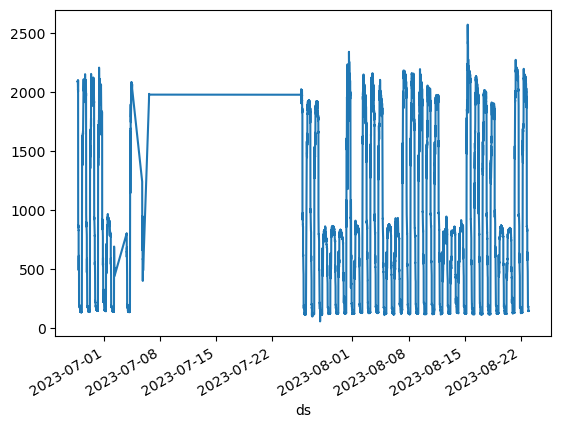

In [17]:
df.set_index('ds')['power'].plot()

<Axes: xlabel='ds'>

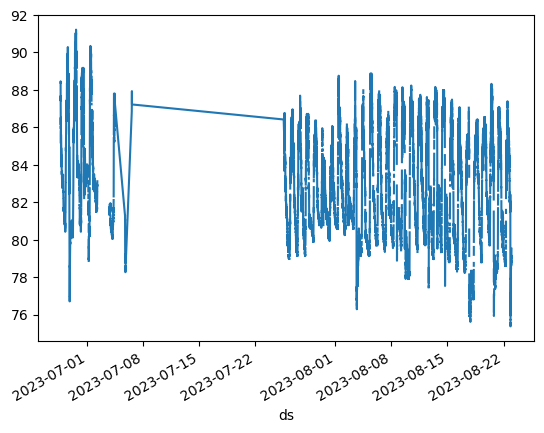

In [20]:
df.set_index('ds')['wetbulb_temperature'].plot()

<Axes: xlabel='ds'>

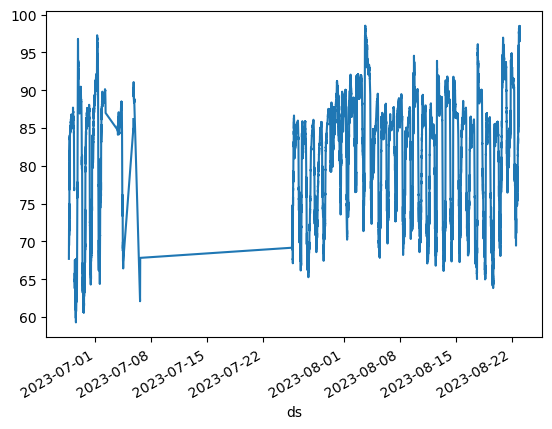

In [21]:
df.set_index('ds')['humidity'].plot()

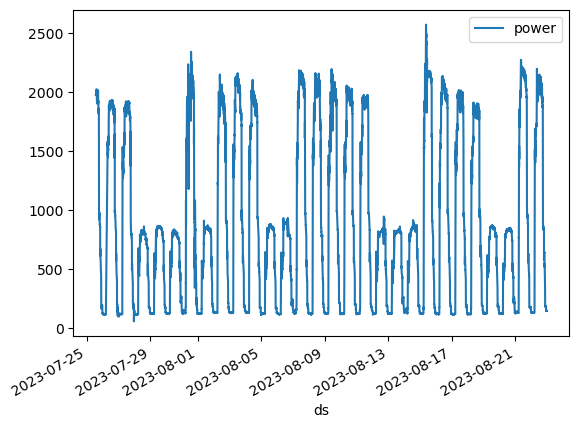

In [118]:
fig, ax = plt.subplots()
df.loc[df['ds'] > pd.to_datetime('2023-07-24')].set_index('ds')['power'].plot(ax=ax)
ax.legend()

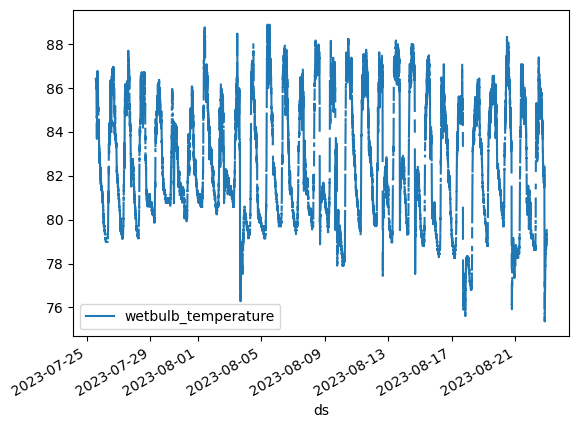

In [124]:
fig, ax = plt.subplots()
df.loc[df['ds'] > pd.to_datetime('2023-07-24')].set_index('ds')['wetbulb_temperature'].plot(ax=ax)
ax.legend()

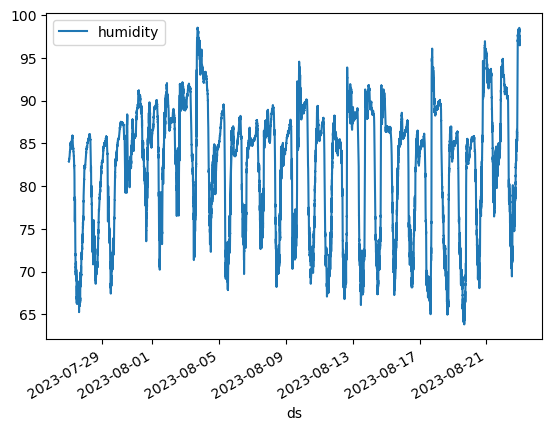

In [415]:
fig, ax = plt.subplots()
df.loc[df['ds'] > pd.to_datetime('2023-07-27')].set_index('ds')['humidity'].plot(ax=ax)
ax.legend()

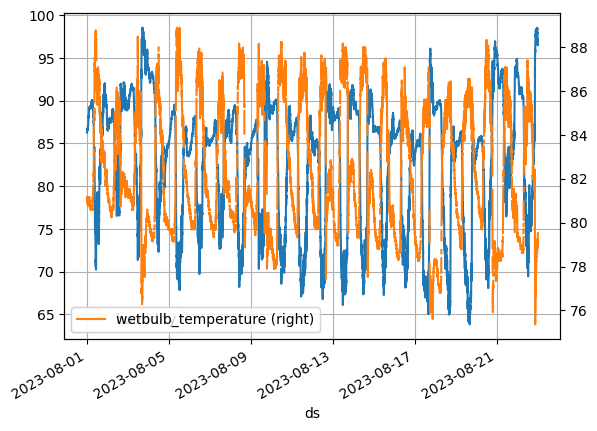

In [72]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-08-01'))
df.loc[cond].set_index('ds')['humidity'].plot(ax=ax)
df.loc[cond].set_index('ds')['wetbulb_temperature'].plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

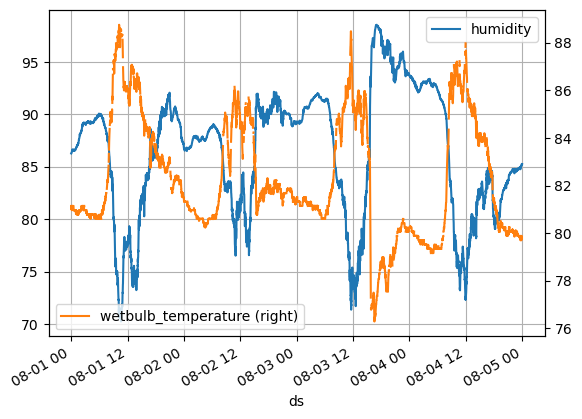

In [71]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-08-01'))& (df['ds'] < pd.to_datetime('2023-08-05'))
df.loc[cond].set_index('ds')['humidity'].plot(ax=ax)
df.loc[cond].set_index('ds')['wetbulb_temperature'].plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

จากการดูคร่าวๆ humidity และ wetbulb_temperature มีความสัมพันธ์แบบตรงข้ามกัน

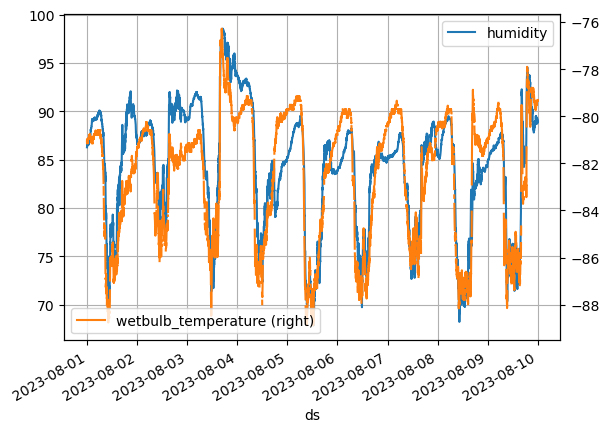

In [70]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-08-01'))& (df['ds'] < pd.to_datetime('2023-08-10'))
df.loc[cond].set_index('ds')['humidity'].plot(ax=ax)
(df.loc[cond].set_index('ds')['wetbulb_temperature']*(-1)).plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

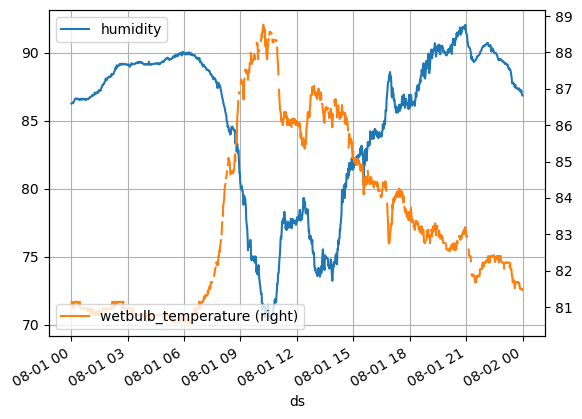

In [73]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-08-01'))& (df['ds'] < pd.to_datetime('2023-08-02'))
df.loc[cond].set_index('ds')['humidity'].plot(ax=ax)
df.loc[cond].set_index('ds')['wetbulb_temperature'].plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

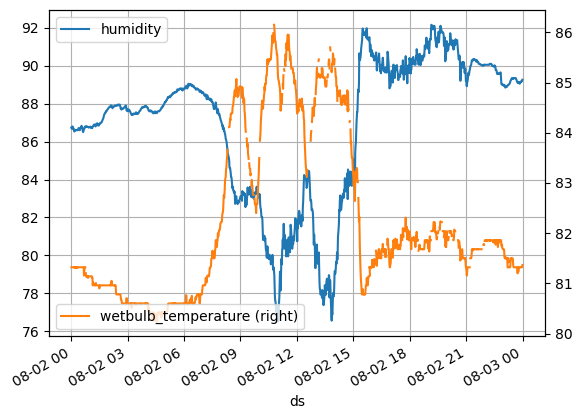

In [74]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-08-02'))& (df['ds'] < pd.to_datetime('2023-08-03'))
df.loc[cond].set_index('ds')['humidity'].plot(ax=ax)
df.loc[cond].set_index('ds')['wetbulb_temperature'].plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

พิจารณาวันหยุด

In [165]:
df = df.set_index('ds')

In [197]:
df['day_off'] = df.index.weekday

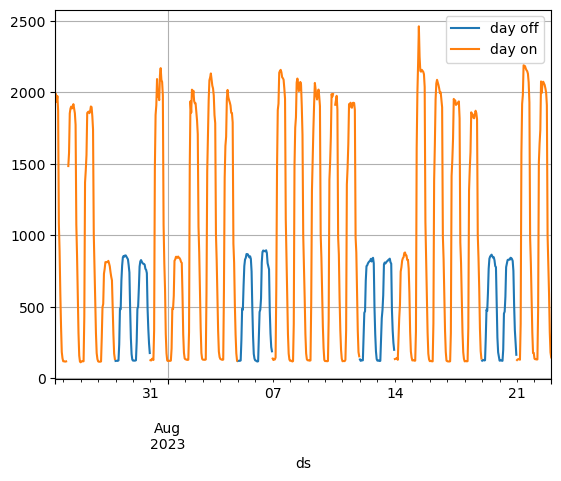

In [206]:
### plot holiday
# from 2023-07-24 to 2023-08-23
cond = (df.index > pd.to_datetime('2023-07-24'))
fig, ax = plt.subplots()
df['power'].loc[((df['day_off']==5) | (df['day_off']==6)) & cond].resample('1H').mean().plot(ax=ax)
df['power'].loc[(((df['day_off']!=5) & (df['day_off']!=6))) & cond].resample('1H').mean().plot(ax=ax)
ax.legend(['day off', 'day on'])
ax.grid()
plt.show()

จะเห็นได้ว่าวันเสาร์อาทิตย์จะมีการใช้พลังงานที่ต่ำและวันอื่นๆที่ต่ำเหมือนกันจะตรงกับวันหยุดของธนาคาร

พิจารณาเทรนรายวัน

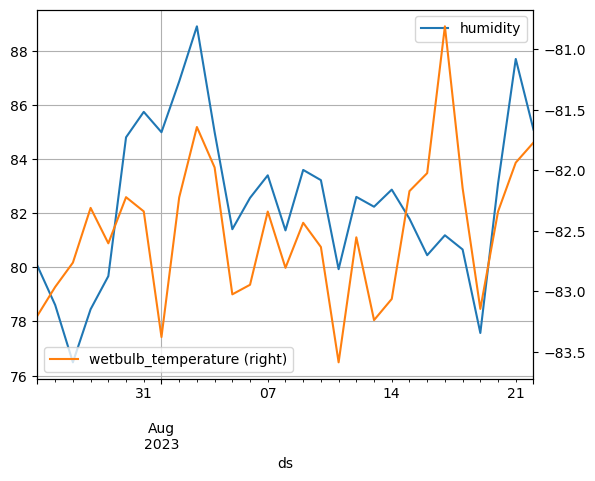

In [126]:
fig, ax = plt.subplots()
cond = (df['ds'] > pd.to_datetime('2023-07-25'))
df[cond].set_index('ds').resample('D').mean()['humidity'].plot(ax=ax)
(df[cond].set_index('ds').resample('D').mean()['wetbulb_temperature']*(-1)).plot(ax=ax,secondary_y=True)
ax.grid()
ax.legend()
ax.right_ax.legend(loc='lower left')

### Problem setting

Goal คือการทำนาย power trends ใน 1 วันถัดไป
- เลือกทำนายเป็นรายโมง 24 ช่วงโมงของวันถัดไป 

1. จัดการ resumpling ข้อมูลเป็นรายชั่วโมง และเก็บเป็นค่าเฉลี่ยของรายชัวโมงนั้นๆ

In [677]:
df = pd.read_csv('data.csv')
df['ds'] = pd.to_datetime(df['ds'])
df_resame = df.set_index('ds').resample('H').mean().copy()

2. เพิ่ม feature ที่เป็นวันหยุดเข้าไป 'day-off'
- วันเสาร์อาทิตย์
- วันหยุดธนาคาร

In [678]:
df_resame['day_off'] = 0
cond1 = df_resame.index.weekday.isin([5,6])
cond2 = (df_resame.index.month == 7)&(df_resame.index.day == 28)
cond3 = (df_resame.index.month == 8)&(df_resame.index.day.isin([1,14]))
df_resame['day_off'].loc[cond1 | cond2 | cond3] = 1

C:\Users\pooms\AppData\Local\Temp\ipykernel_4612\1574464478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resame['day_off'].loc[cond1 | cond2 | cond3] = 1


3.จะเห็นว่าจริงๆแล้วการใช้ไฟ กับ ไม่ใช้ไฟไม่ได้ขึ้นกับข้อมูลในอดีต ขึ้นกับเพียงแค่ 
- คนเข้า office หรือไม่ 
- อาจจะขึ้นกับผลของอุณหภูมิและความชื้น 

ดังนั้นจริงๆแล้ว เพียงแค่เราสามารถคาดการสองตัวแปรหลังได้และรู้ว่าวันนั้นๆมีคนเข้า office หรือไม่ก็เพียงพอที่จะคาดการปริมาณไฟฟ้าได้แล้ว

- สมมติว่ารู้ค่า 'wetbulb_temperature' กับ 'humidity'   
ทำการ train multioutput regression ของ power

In [686]:
# generate new dataframe
df_resame.loc[df_resame.index.hour ==1]
cond1 = (df_resame.index < pd.to_datetime('2023-07-02'))
cond2 = (df_resame.index >= pd.to_datetime('2023-07-27'))
cond3 = (df_resame.index != pd.to_datetime('2023-08-10'))

In [687]:
df_resame = df_resame[(cond1 | cond2)&cond3].loc[df_resame['power'].isna() != True]

In [690]:
df_resame.isna().sum()

power                  0
wetbulb_temperature    0
humidity               0
day_off                0
dtype: int64

In [691]:
df_x = pd.DataFrame()
df_y = pd.DataFrame()
for j in ['wetbulb_temperature', 'humidity']:
    for i in range(24):
        df_x[j+str(i)] = pd.DataFrame(df_resame.loc[df_resame.index.hour ==i][j].to_list()) 
for i in range(24):
    df_y['y'+str(i)] = pd.DataFrame(df_resame.loc[df_resame.index.hour ==i]['power'].to_list())  
df_x['day_off'] = pd.DataFrame(df_resame.loc[df_resame.index.hour ==0]['day_off'].to_list()) 

In [692]:
x_train, x_test, y_train, y_test = train_test_split(df_x.values, df_y.values, random_state = 100, test_size=0.4)

In [693]:
model = MultiOutputRegressor(Ridge(random_state=123))
model.fit(x_train,y_train)
model.score(x_test, y_test)

-3.4615597779218152

ผลลัพธ์ของ test set

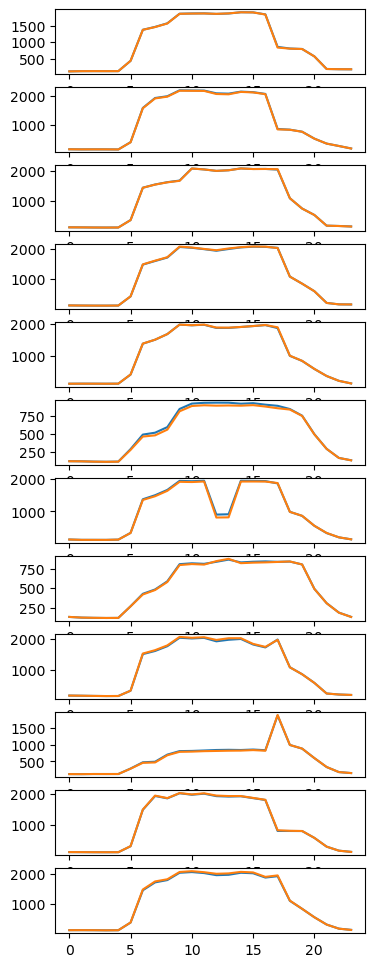

In [694]:
fig, ax = plt.subplots(x_test.shape[0],figsize = (4,x_test.shape[0]))
for i in range(x_test.shape[0]):
    ax[i].plot(np.linspace(0,23,24),model.predict(x_train)[i])
    ax[i].plot(np.linspace(0,23,24),y_train[i])

$ \frac{1}{N}\sum (\hat{y} - y_{true})^2 $
error =  498802.9650829723

error =  498802.9650829723


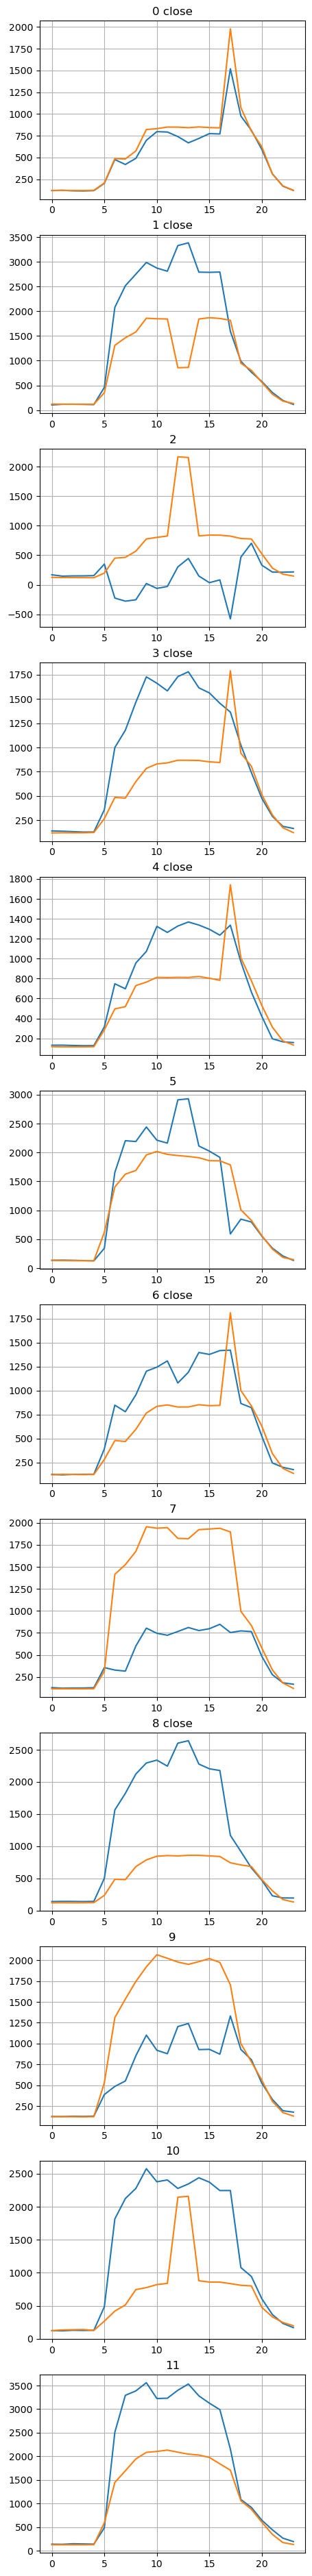

In [744]:
fig, ax = plt.subplots(x_test.shape[0],figsize = (5,x_test.shape[0]*4))
for i in range(x_test.shape[0]):
    ax[i].plot(np.linspace(0,23,24),model.predict(x_test)[i])
    ax[i].plot(np.linspace(0,23,24),y_test[i])
    ax[i].set_title(str(i))
    ax[i].set_title(str(i)+" close"*int(x_test[i][-1]))
    ax[i].grid()
print("error = ",((model.predict(x_test) - y_test)**2).sum()/y_test.size)

(12, 24)

การใช้ multioutput regression โดย assume ว่าสามารถประมาณ humid temp และรู้วันเปดปิดสำนักงานก็ยังไม่แม่นยำพอที่จะ ทำนาย power ได้

In [708]:
# fitting
model2 = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear')).fit(x_train, y_train)

c:\Users\pooms\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\pooms\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [17:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


error =  2.3483352503301702e-07


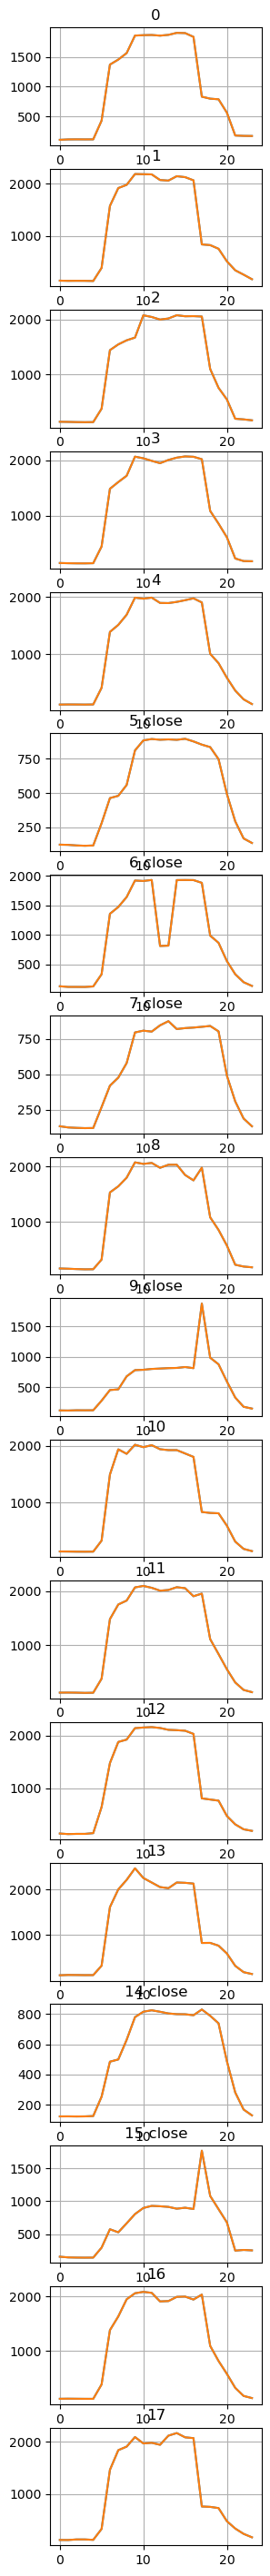

In [753]:
fig, ax = plt.subplots(x_train.shape[0],figsize = (3,x_train.shape[0]*2))
for i in range(x_train.shape[0]):
    ax[i].plot(np.linspace(0,23,24),model2.predict(x_train)[i])
    ax[i].plot(np.linspace(0,23,24),y_train[i])
    ax[i].set_title(str(i)+" close"*int(x_train[i][-1]))
    ax[i].grid()
print("error = ",((model2.predict(x_train) - y_train)**2).sum()/y_train.size)

error =  146030.76619140498


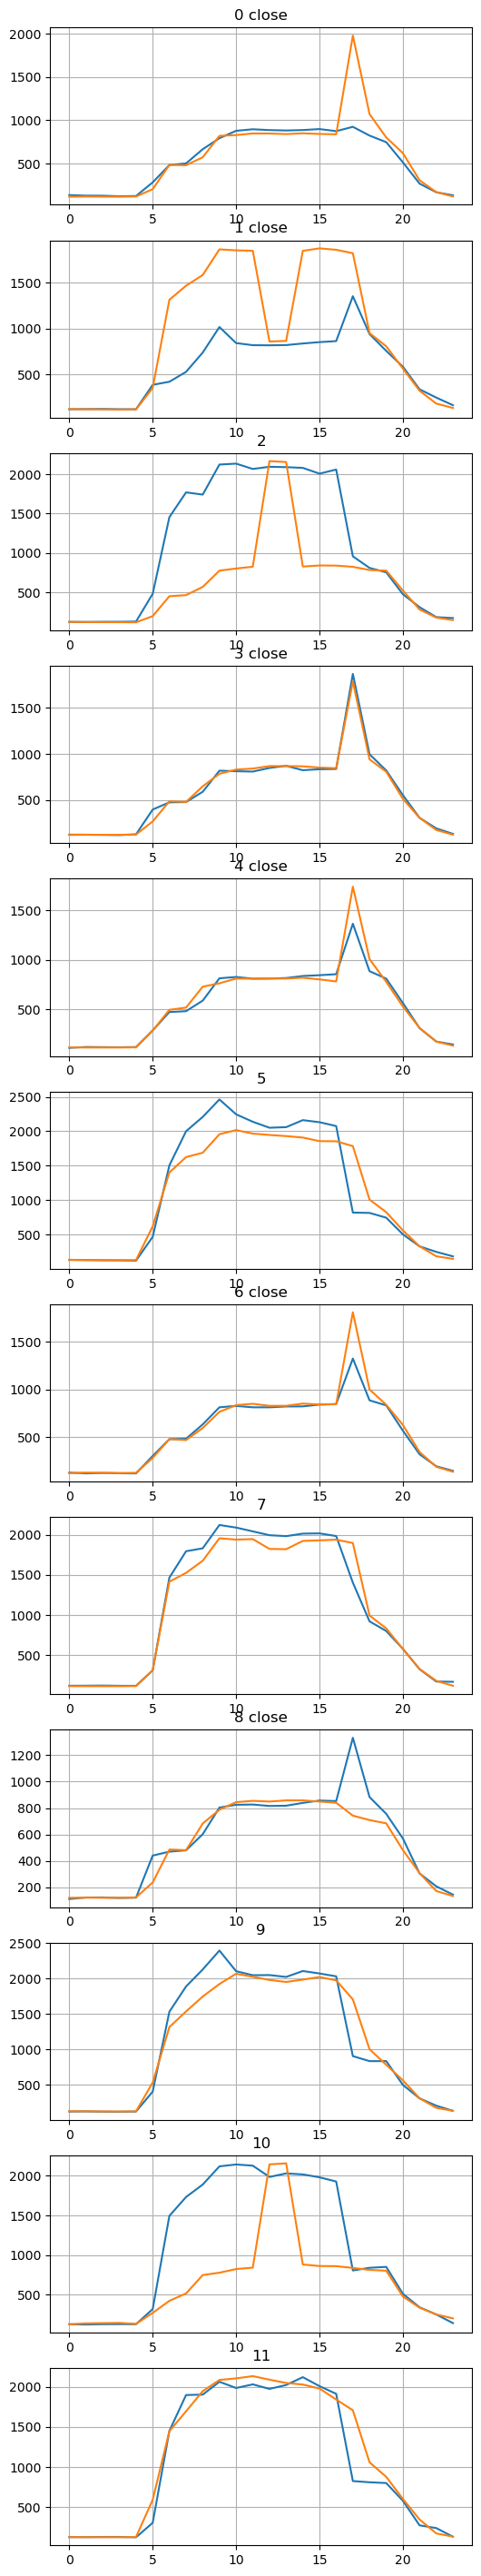

In [734]:
fig, ax = plt.subplots(x_test.shape[0],figsize = (6,x_test.shape[0]*3))
for i in range(x_test.shape[0]):
    ax[i].plot(np.linspace(0,23,24),model2.predict(x_test)[i])
    ax[i].plot(np.linspace(0,23,24),y_test[i])
    ax[i].set_title(str(i)+" close"*int(x_test[i][-1]))
    ax[i].grid()
print("error = ",((model2.predict(x_test) - y_test)**2).sum()/y_test.size)

4. ทำนายอนุกรมเวลาของ temp และ humid 